# Bandwidth Extension of undersampled reconstructed room impulse responses

### Imports

In [1]:
import sys
import matplotlib.patches as mpatches
sys.path.append('../..')
from src.models.HiFiGAN.inference import run_inference as hifi_inference
from src.models.CSGM.run_CSGM import inference as csgm_inference
from src.models.SEGAN.inference import run_inference as segan_inference
import warnings
warnings.filterwarnings('ignore')
from aux_func import *
import pathlib

## Prepare directories

In [2]:
# inference file paths
csgmfilepath = pathlib.Path("..", "models", "CSGM", "inference_data")
hififilepath = pathlib.Path("..", "models", "HiFiGAN", "generated_files")
seganfilepath = pathlib.Path("..", "models", "SEGAN", "generated_files")
npzfilecsgm = os.path.join(str(csgmfilepath), 'inference_data.npz')
npzfilesegan = os.path.join(str(seganfilepath), 'generator_inference_file.npz')
npzfilehifi = os.path.join(str(hififilepath), 'generator_inference_file.npz')
npzfilehifiproc = os.path.join(str(hififilepath), 'generator_inference_processed.npz')
# validation data path (e.g. input to neural networks and ground truths)
validation_data_path = pathlib.Path("..", "..", "data", "Inference Data")
# network weights paths
hifi_checkpoint_path = pathlib.Path("..",  "models", "HiFiGAN", "checkpoints_generator")
segan_checkpoint_path = pathlib.Path("..", "models", "SEGAN", "checkpoints_generator")
csgm_checkpoint_path = pathlib.Path("..", "models", "CSGM", "Generator_checkpoints")
# output paths
hifi_output_path = pathlib.Path("..",  "models", "HiFiGAN", "generated_files")
segan_output_path = pathlib.Path("..", "models", "SEGAN", "generated_files")
csgm_output_path = pathlib.Path("..", "models", "CSGM", "generated_files")
# config files
hifi_config_path = pathlib.Path("..", "..", "config", "HiFiGAN_config.yaml")
segan_config_path = pathlib.Path("..", "..", "config", "SEGAN_config.yaml")
csgm_config_path = pathlib.Path("..", "..", "config", "CSGM_config.yaml")


## Run inference

# HiFi GAN

In [3]:
hifi_inference(validation_dir = str(validation_data_path.absolute()), checkpoint_dir = str(hifi_checkpoint_path.absolute()),output_dir = str(hifi_output_path.absolute()), config_file = str(hifi_config_path.absolute()) )

Initializing Inference Process..
Loading '/home/xen/PhD/Repositories/BandwidthExtensionRIRs_/src/visualization/../models/HiFiGAN/checkpoints_generator/g_specialCase'
Complete.


  0%|          | 0/15 [00:00<?, ?it/s]

Inference RIRs saved in path:  /home/xen/PhD/Repositories/BandwidthExtensionRIRs_/src/visualization/../models/HiFiGAN/generated_files/generator_inference_file.npz


# CSGM

The following inference / optimisation step is best run using a gpu

In [9]:
csgm_inference( config_file=str(csgm_config_path.absolute()), checkpoint_dir=str(csgm_checkpoint_path), adaptive_gan=True, inference_dir=str(csgm_output_path.absolute()), get_metrics= False, validation_dir =  str(validation_data_path.absolute()))

Loading '../models/CSGM/Generator_checkpoints/g_00129000'
Complete.
--------------------------------------------------------------------------------
Reconstructing a total of 15 RIRs.
Will perform csgm optimisation for 10 latent variable initialisations.
--------------------------------------------------------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Running CSGM:


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Conditional GAN (SEGAN)

In [4]:
segan_inference(validation_dir= str(validation_data_path.absolute()), checkpoint_dir= str(segan_checkpoint_path.absolute()), output_dir= str(segan_output_path.absolute()), config_file=str(segan_config_path.absolute()))

Initializing Inference Process..
Loading '/home/xen/PhD/Repositories/BandwidthExtensionRIRs_/src/visualization/../models/SEGAN/checkpoints_generator/g_00393000'
Complete.


0it [00:00, ?it/s]

Inference RIRs saved in path:  /home/xen/PhD/Repositories/BandwidthExtensionRIRs_/src/visualization/../models/SEGAN/generated_files/generator_inference.npz


### Save inference data

In [12]:
save_rirs()

### Run metrics estimation

In [13]:
run_metrics()

Getting metrics for response : 15/15: 100%|██████████| 15/15 [00:00<00:00, 38.25it/s]


### Plot RIRs and Frequency Resp. including ground truth and all reconstructions

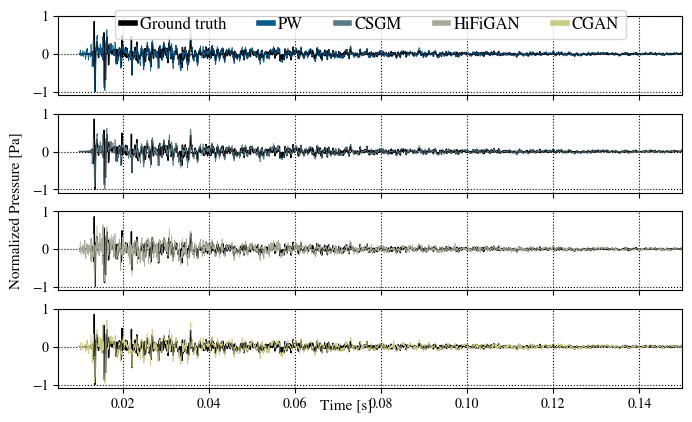

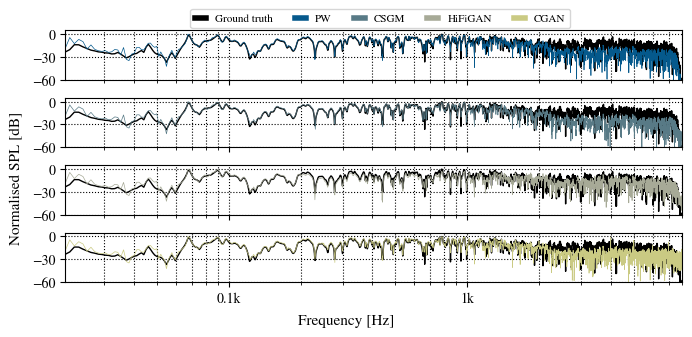

In [5]:
rir_indexes = [2]
# rir_indexes = [0, 2, 5, 8, 10, 13, 14]
for ind in rir_indexes:
    plot_all_rirs(index=ind)
    plot_all_frfs(index=ind)


### Plot time domain metrics

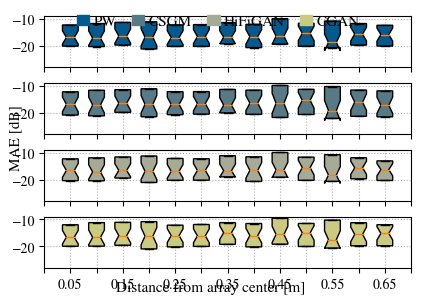

In [7]:
""" Plot td metrics"""
metric = 'mae'
response_numbers = np.arange(0, 15)
PWdata = []
SEGANdata = []
HiFidata = []
CSGMdata = []
_, hifidata, _ = get_data()
grid_ref = hifidata['grid_ref']
r = np.linalg.norm(grid_ref[:2], axis=0).round(2)
r, rind = np.unique(r, return_index= True)

for response_number in response_numbers[rind]:
    h5path1 = os.path.join(str(seganfilepath),f'metrics_inference_{response_number}.h5')
    h5path2 = os.path.join(str(hififilepath),f'metrics_inference_{response_number}.h5')
    h5path3 = os.path.join(str(csgmfilepath),f'metrics_inference_{response_number}.h5')
    metrics_SEGAN = config_metrics(h5path1)
    metrics_hifi = config_metrics(h5path2)
    metrics_csgm = config_metrics(h5path3)
    PWdata.append(metrics_SEGAN[f'td_plwav{metric}'])
    SEGANdata.append(metrics_SEGAN[f'td_gan{metric}'] )
    HiFidata.append(metrics_hifi[f'td_gan{metric}'])
    CSGMdata.append(metrics_csgm[f'td_gan{metric}'])

plot_dict = {
    'PW': np.array(PWdata),
    'CSGM': np.array(CSGMdata),
    'HiFiGAN': np.array(HiFidata),
    'CGAN': np.array(SEGANdata)
}
plot_settings()
fsize = get_figsize(wf = 1.2, hf = .7)

# fig,ax = plt.subplots(sharex= True, sharey = True)

fig = plt.figure(figsize = fsize)
# fig = plt.figure(figsize=(width, 5 * width / 6))
fig = plot_subplots_box_plot(fig, plot_dict,r)
# ax.set_xlim(11, 8000)
colpatches = []
for ii, key in enumerate(plot_dict.keys()):
    colpatches.append(mpatches.Patch(color=colors[ii], label=key))

fig.legend(handles=colpatches, bbox_to_anchor=(0.88, 1.001),
           borderaxespad=0.,
           handlelength=0.8, handletextpad = 0.3,
           handleheight = 0.6, columnspacing = 1.,
           bbox_transform = plt.gcf().transFigure,
           ncol=4, frameon=False,
           fontsize = 11)
# fig.supylabel('MAE [dB]', fontsize = 10, )
# fig.supxlabel('Distance from array center [m]', fontsize = 10)
fig.text(0.5, 0.015,'Distance from array center [m]', fontsize = 11,  ha='center')
fig.text(0.008, 0.45, 'MAE [dB]', fontsize = 11, rotation='vertical')
fig.tight_layout()
fig.subplots_adjust(wspace=None, hspace=0.2)
fig.show()


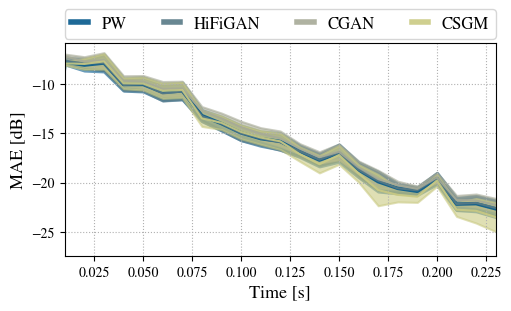

In [8]:
""" Plot td metrics"""
metric = 'mae'
response = 0
response_numbers = np.arange(0, 15)
PWdata = []
SEGANdata = []
HiFidata = []
CSGMdata = []
# for response_number in response_numbers[response:response + 1]:
for response_number in response_numbers:
    h5path1 = os.path.join(str(seganfilepath),f'metrics_inference_{response_number}.h5')
    h5path2 = os.path.join(str(hififilepath),f'metrics_inference_{response_number}.h5')
    h5path3 = os.path.join(str(csgmfilepath),f'metrics_inference_{response_number}.h5')
    metrics_SEGAN = config_metrics(h5path1)
    metrics_hifi = config_metrics(h5path2)
    metrics_csgm = config_metrics(h5path3)
    PWdata.append(metrics_hifi[f'td_plwav{metric}'])
    SEGANdata.append(metrics_SEGAN[f'td_gan{metric}'], )
    HiFidata.append(metrics_hifi[f'td_gan{metric}'])
    CSGMdata.append(metrics_csgm[f'td_gan{metric}'])
    t = metrics_csgm['time_intervals']

plot_dict = {
    'PW': np.squeeze(PWdata),
    'HiFiGAN': np.squeeze(HiFidata),
    'CGAN': np.squeeze(SEGANdata),
    'CSGM': np.squeeze(CSGMdata)
}
figsize = (5,3)
fig, ax = plt.subplots(figsize=figsize)
ax = plot_td_corr_data(t, plot_dict, ylabel='MAE [dB]', switchcolors=True)
# ax.set_ylim([0.2, 0.8])
ax.set_xlim([0.01, .23])
fig.show()

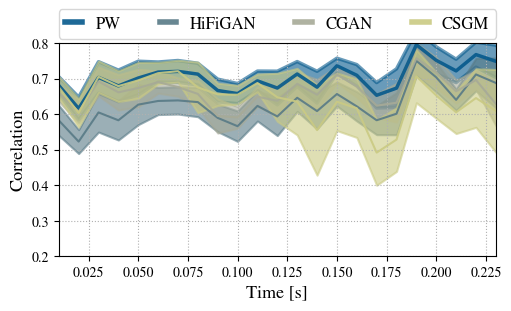

In [9]:
""" Plot td metrics"""
metric = 'corr'
response = 0
response_numbers = np.arange(0, 15)
PWdata = []
SEGANdata = []
HiFidata = []
CSGMdata = []
# for response_number in response_numbers[response:response + 1]:
for response_number in response_numbers:
    h5path1 = os.path.join(str(seganfilepath),f'metrics_inference_{response_number}.h5')
    h5path2 = os.path.join(str(hififilepath),f'metrics_inference_{response_number}.h5')
    h5path3 = os.path.join(str(csgmfilepath),f'metrics_inference_{response_number}.h5')
    metrics_SEGAN = config_metrics(h5path1)
    metrics_hifi = config_metrics(h5path2)
    metrics_csgm = config_metrics(h5path3)
    PWdata.append(metrics_hifi[f'td_plwav{metric}'])
    SEGANdata.append(metrics_SEGAN[f'td_gan{metric}'], )
    HiFidata.append(metrics_hifi[f'td_gan{metric}'])
    CSGMdata.append(metrics_csgm[f'td_gan{metric}'])
    t = metrics_csgm['time_intervals']

plot_dict = {
    'PW': np.squeeze(PWdata),
    'HiFiGAN': np.squeeze(HiFidata),
    'CGAN': np.squeeze(SEGANdata),
    'CSGM': np.squeeze(CSGMdata)
}
figsize = (5,3)
fig, ax = plt.subplots(figsize=figsize)
ax = plot_td_corr_data(t, plot_dict, ylabel='Correlation', switchcolors=True)
ax.set_ylim([0.2, 0.8])
ax.set_xlim([0.01, .23])
fig.show()

### Plot Frequency domain metrics

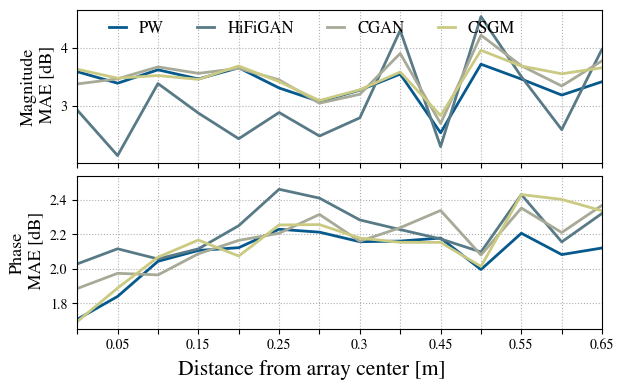

In [10]:
metric = 'mae'
quantity = 'mag'
plot_dict1, r = fdmetric(metric, quantity)
# metric = 'nmse'
quantity = 'phase'
plot_dict2, _ = fdmetric(metric, quantity)
# fig,ax = plt.subplots(figsize=(width, width/2))
figsize = plot_settings()
figsize = plot_settings()
fig, ax = plt.subplots(2,1, sharex = True, figsize=(1.8*figsize[0], 1.8*figsize[1]))
ax[0] = plot_freq_position_data(r, plot_dict1, ylabel = 'Magnitude\n MAE [dB]', ax = ax[0])
ax[1] = plot_freq_position_data(r, plot_dict2, ylabel = 'Phase\n MAE [dB]', ax = ax[1])
ax[0].set_xlim([0., 13])
# ax[0].set_ylim([.4, 4])
# ax[1].set_ylim([1.8, 3])
handles_1, labels_1 = ax[0].get_legend_handles_labels()

fig.subplots_adjust(wspace=0.05, hspace=0.05)

legend = fig.legend(handles_1, labels_1, bbox_to_anchor=(0., 0.9, 1., .102), loc='lower center',
                    ncol=4,  borderaxespad=0., handlelength=1, frameon=False)
fig.supxlabel(r'Distance from array center [m]')
fig.show()

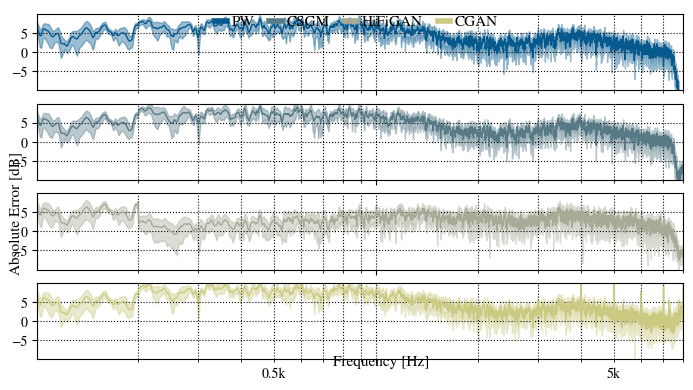

In [11]:
plot_broadband_error_dist(magnitude=True)

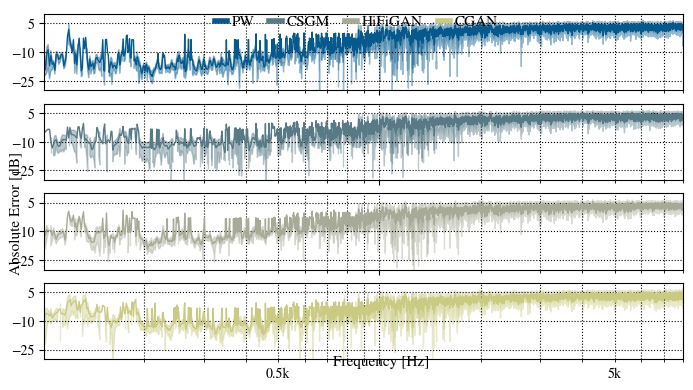

In [12]:
plot_broadband_error_dist(magnitude=False)
